In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
os.getcwd()


'/content'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
for dirname, _, filenames in os.walk('/content/'):
    print(dirname)


/content/
/content/.config
/content/.config/configurations
/content/.config/logs
/content/.config/logs/2020.08.27
/content/drive
/content/drive/My Drive
/content/drive/My Drive/Kranthi
/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/butter
/content/drive/My Drive/butter/leedsbutterfly
/content/drive/My Drive/butter/leedsbutterfly/images
/content/drive/My Drive/butter/leedsbutterfly/segmentations
/content/drive/My Drive/butter/leedsbutterfly/descriptions
/content/drive/.shortcut-targets-by-id
/content/drive/.Trash
/content/sample_data


In [67]:
data = pd.read_csv("/content/drive/My Drive/r_dataisbeautiful_posts.csv")


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [68]:
data.describe()

,score,total_awards_received,created_utc,num_comments
count,183891.000000,44007.000000,1.838910e+05,183891.000000
mean,186.652131,0.003636,1.497016e+09,25.382248
std,1969.835481,0.129975,6.372761e+07,195.622576
min,0.000000,0.000000,1.329263e+09,0.000000
25%,1.000000,0.000000,1.447768e+09,1.000000
50%,1.000000,0.000000,1.496235e+09,1.000000
75%,5.000000,0.000000,1.554152e+09,4.000000
max,116226.000000,12.000000,1.592565e+09,18801.000000


In [14]:
data.dtypes

id                        object
title                     object
score                      int64
author                    object
author_flair_text         object
removed_by                object
total_awards_received    float64
awarders                  object
created_utc                int64
full_link                 object
num_comments               int64
over_18                     bool
dtype: object

In [69]:
data.title=data.title.astype(str)
data.over_18=data.over_18.astype(int)

In [70]:
import seaborn as sns
import os
import re
import string

import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas.util.testing as tm
from wordcloud import WordCloud
from tqdm.auto import tqdm
import matplotlib.style as style
style.use('fivethirtyeight')
from sklearn.metrics import plot_roc_curve
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [71]:
data.head()


,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,hbyv2e,[OC] How Bar Chart Race Animation Can be Creat...,1,Tom10AE,NaN,NaN,0.0,[],1592565317,https://www.reddit.com/r/dataisbeautiful/comme...,0,0
1,hbynoy,[UK] Labour and Conservative vote share by age...,1,Ge0rgeBr0ughton,NaN,NaN,0.0,[],1592564316,https://www.reddit.com/r/dataisbeautiful/comme...,1,0
2,hbym2y,[NOC] Number of wallets returned across the wo...,1,i_am_shattered,NaN,NaN,0.0,[],1592564089,https://www.reddit.com/r/dataisbeautiful/comme...,1,0
3,hbyirw,Largest Banana Producing Countries (1961-2020)...,1,Bilal078692,NaN,moderator,0.0,[],1592563628,https://www.reddit.com/r/dataisbeautiful/comme...,0,0
4,hby1fy,[OC] Popular Combinations for the StamiStudios...,1,shahinrostami,Viz Researcher,NaN,0.0,[],1592561119,https://www.reddit.com/r/dataisbeautiful/comme...,2,0


In [72]:
(data.isnull().sum() / len(data)) * 100


id                        0.000000
title                     0.000000
score                     0.000000
author                    0.000000
author_flair_text        86.636649
removed_by               93.711492
total_awards_received    76.068976
awarders                 81.874045
created_utc               0.000000
full_link                 0.000000
num_comments              0.000000
over_18                   0.000000
dtype: float64

In [73]:
data=data[["title","score","author","num_comments","over_18"]]


In [74]:
data.head()

,title,score,author,num_comments,over_18
0,[OC] How Bar Chart Race Animation Can be Creat...,1,Tom10AE,0,0
1,[UK] Labour and Conservative vote share by age...,1,Ge0rgeBr0ughton,1,0
2,[NOC] Number of wallets returned across the wo...,1,i_am_shattered,1,0
3,Largest Banana Producing Countries (1961-2020)...,1,Bilal078692,0,0
4,[OC] Popular Combinations for the StamiStudios...,1,shahinrostami,2,0


In [23]:
len(data)

183891

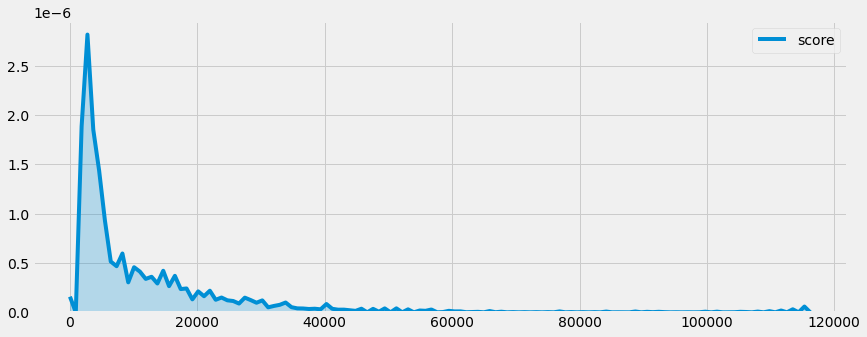

In [75]:
plt.figure(figsize=(13,5))

sns.kdeplot(data['score'], shade=  True)


In [35]:
print(len(data[data['score'] < 10]), 'Posts with less than 10 votes')
print(len(data[data['score'] > 10]), 'Posts with more than 10 votes')


150491 Posts with less than 10 votes
31696 Posts with more than 10 votes


In [76]:
def remove_line_breaks(text):
    text = text.replace('\r', ' ').replace('\n', ' ')
    return text

#remove punctuation
def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")  # such as __NAME__, __LINK__
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    '''Escape all the characters in pattern except ASCII letters and numbers'''
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(" ", token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def lowercase(text):
    text_low = [token.lower() for token in word_tokenize(text)]
    return ' '.join(text_low)

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    text = " ".join([word for word in word_tokens if word not in stop])
    return text

#remobe one character words
def remove_one_character_words(text):
    '''Remove words from dataset that contain only 1 character'''
    text_high_use = [token for token in word_tokenize(text) if len(token)>1]      
    return ' '.join(text_high_use)   
    
#%%
# Stemming with 'Snowball stemmer" package
def stem(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in word_tokenize(text)]        
    return ' '.join(text_stemmed)

def lemma(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in word_tokens])       
    return ' '.join(text_lemma)


#break sentences to individual word list
def sentence_word(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens
#break paragraphs to sentence token 
def paragraph_sentence(text):
    sent_token = nltk.sent_tokenize(text)
    return sent_token    


def tokenize(text):
    """Return a list of words in a text."""
    return re.findall(r'\w+', text)

def remove_numbers(text):
    no_nums = re.sub(r'\d+', '', text)
    return ''.join(no_nums)



def clean_text(text):
    _steps = [
    remove_line_breaks,
    remove_one_character_words,
    remove_special_characters,
    lowercase,
    remove_punctuation,
    remove_stopwords,
    stem,
    remove_numbers
]
    for step in _steps:
        text=step(text)
    return text   


In [77]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [78]:
data['clean_title'] = pd.Series([clean_text(i) for i in tqdm(data1['title'])])


In [47]:
words

array(['oc bar chart race anim creat covid confirm case built automat adob effect',
       'uk labour conserv vote share age group ',
       'noc number wallet return across world', ..., 'wavii',
       'interact represent pres obama  budget propos',
       'map show geograph distribut lactos intoler'], dtype=object)

In [57]:
ls = []

for i in words:
    ls.append(str(i))


In [58]:
ls[:5]


['oc bar chart race anim creat covid confirm case built automat adob effect',
 'uk labour conserv vote share age group ',
 'noc number wallet return across world',
 'largest banana produc countri  oc',
 'oc popular combin stamistudio everyday ita bag']

(-0.5, 1599.5, 799.5, -0.5)

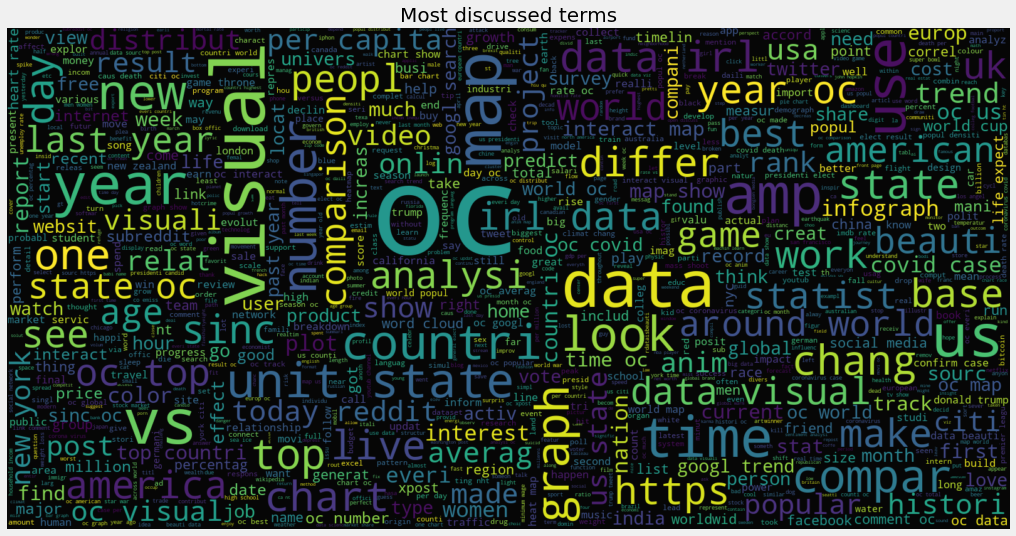

In [59]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=1000, max_font_size= 200,  width=1600, height=800)
wc.generate(" ".join(ls))
plt.title("Most discussed terms", fontsize=20)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.98, interpolation="bilinear", )
plt.axis('off')


In [60]:
most_pop = data.sort_values('score', ascending =False)[['title', 'score']].head(12)

most_pop['score1'] = most_pop['score']/1000


Text(0.5, 1.0, 'Most popular posts')

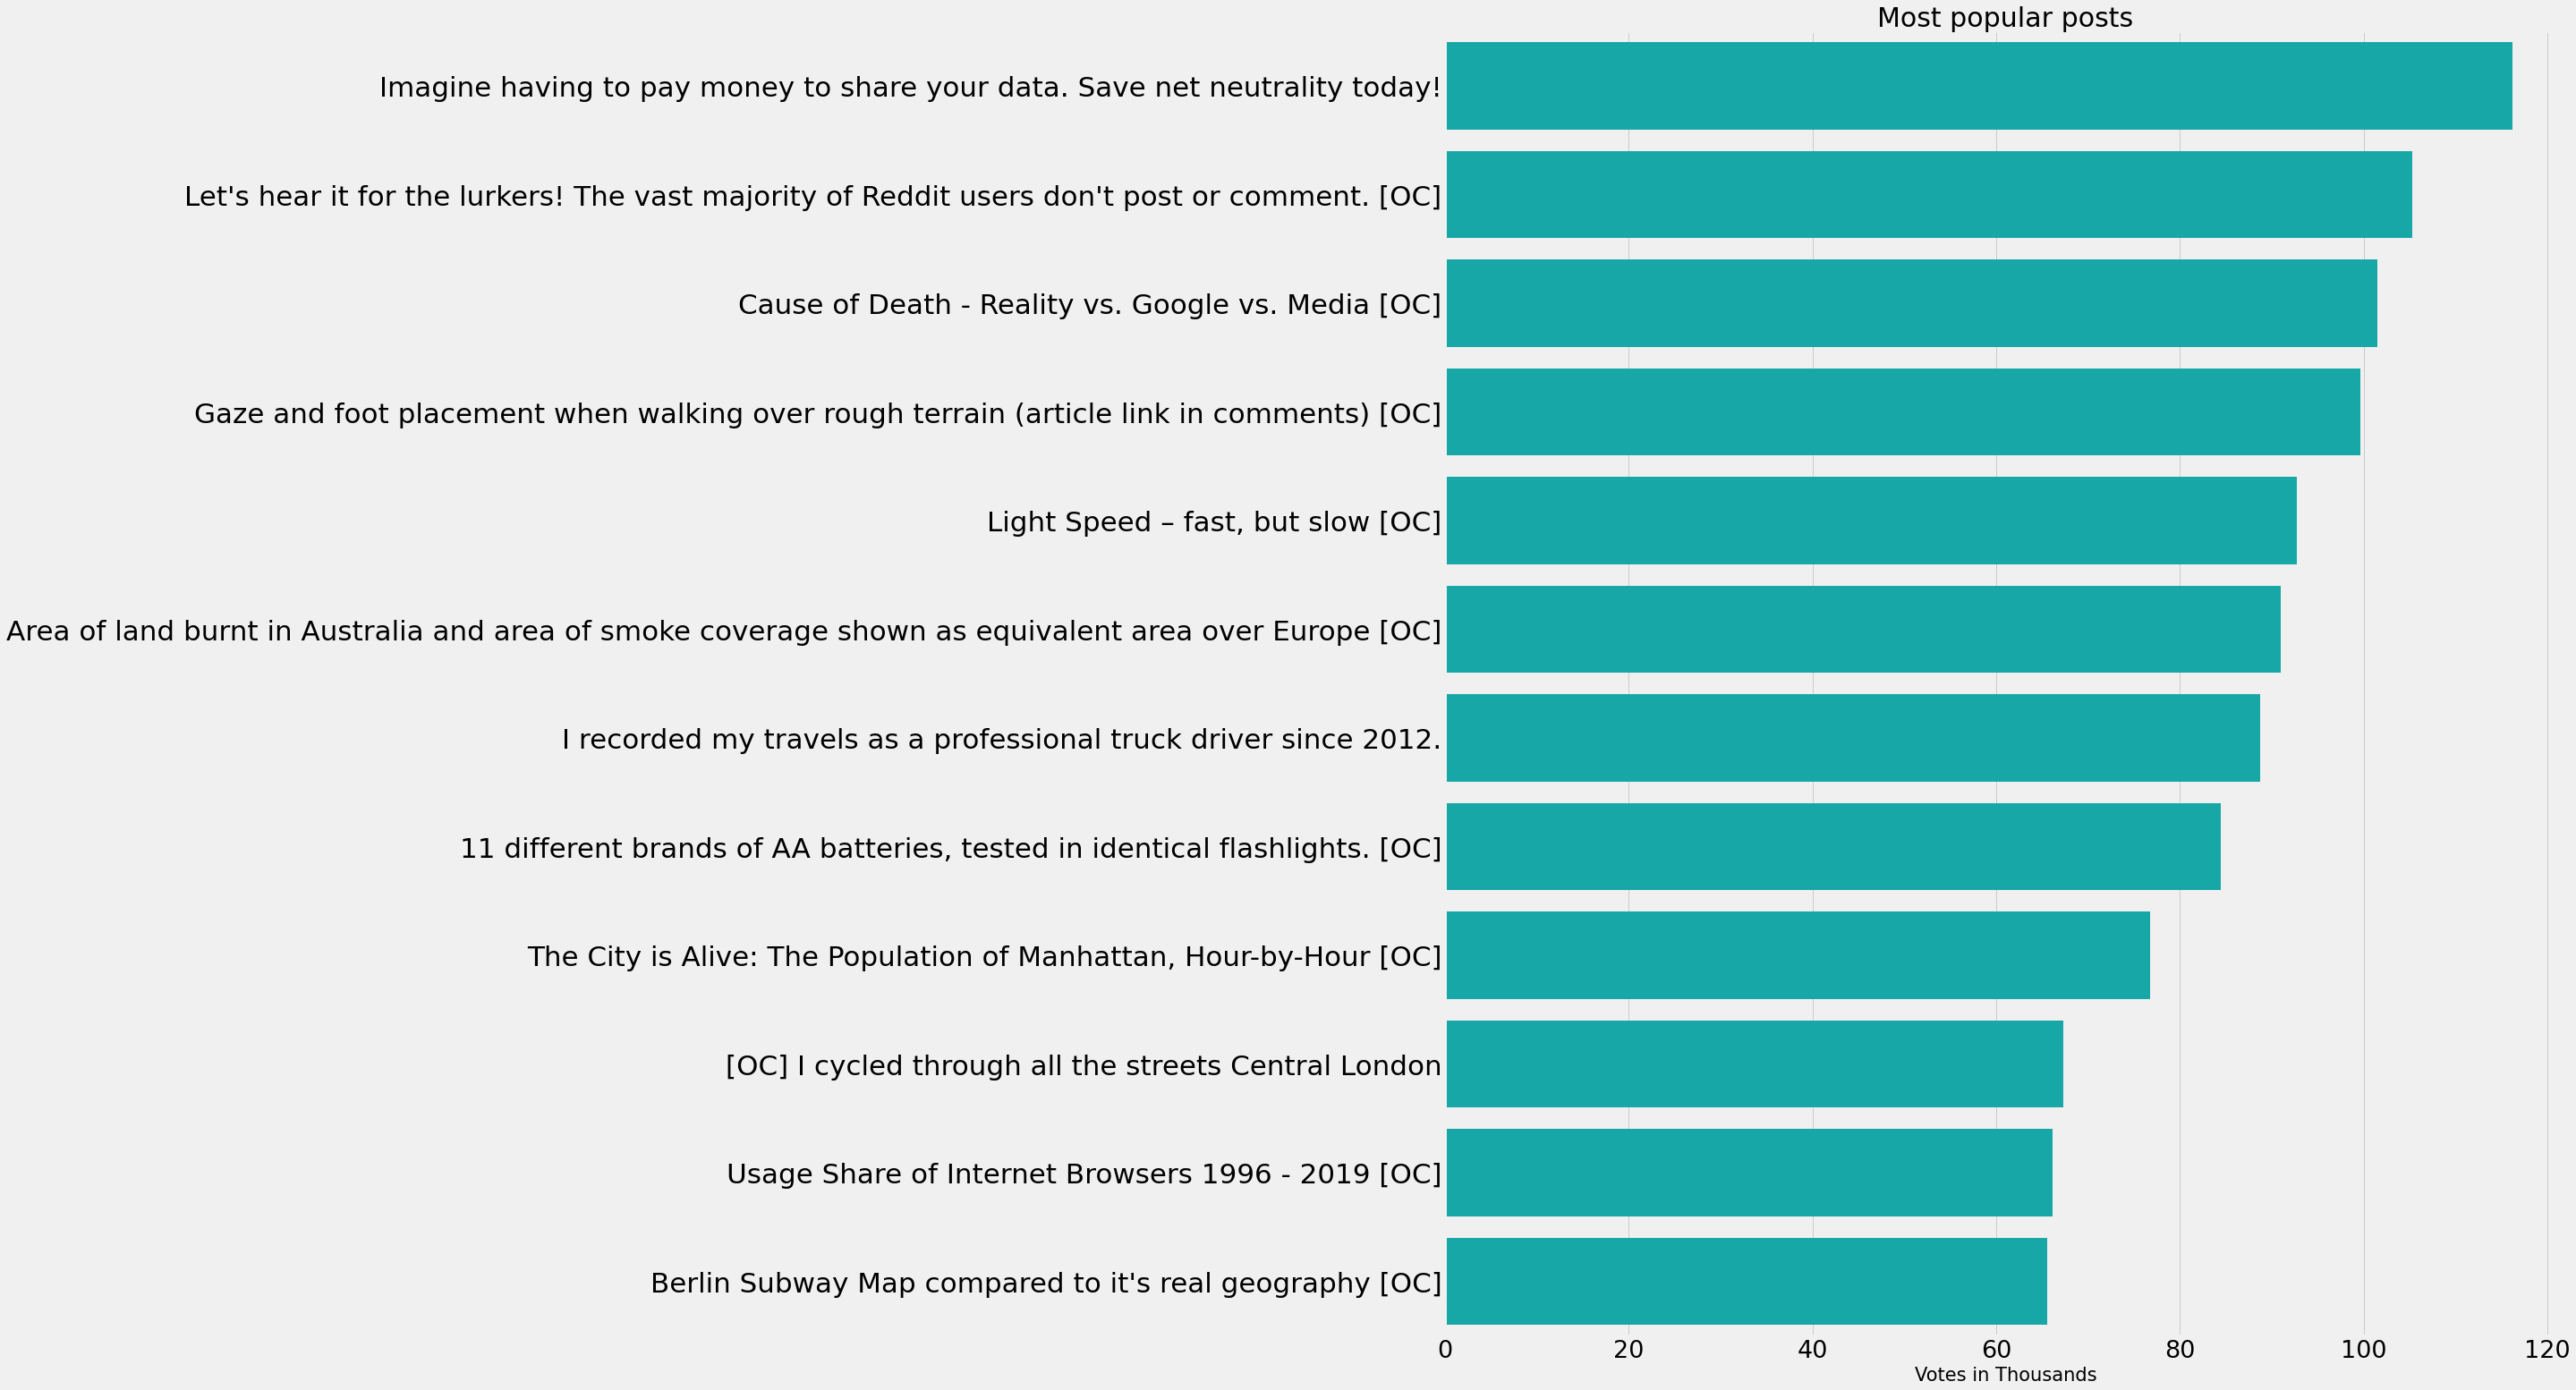

In [61]:
plt.figure(figsize = (20,25))

sns.barplot(data = most_pop, y = 'title', x = 'score1', color = 'c')
plt.xticks(fontsize=27, rotation=0)
plt.yticks(fontsize=31, rotation=0)
plt.xlabel('Votes in Thousands', fontsize = 21)
plt.ylabel('')
plt.title('Most popular posts', fontsize = 30)


In [79]:

data.head()


,title,score,author,num_comments,over_18,clean_title
0,[OC] How Bar Chart Race Animation Can be Creat...,1,Tom10AE,0,0,oc bar chart race anim creat covid confirm cas...
1,[UK] Labour and Conservative vote share by age...,1,Ge0rgeBr0ughton,1,0,uk labour conserv vote share age group
2,[NOC] Number of wallets returned across the wo...,1,i_am_shattered,1,0,noc number wallet return across world
3,Largest Banana Producing Countries (1961-2020)...,1,Bilal078692,0,0,largest banana produc countri oc
4,[OC] Popular Combinations for the StamiStudios...,1,shahinrostami,2,0,oc popular combin stamistudio everyday ita bag


In [80]:
from sklearn.utils import resample


In [81]:
# Separate majority and minority classes
df_majority = data[data.over_18==0]
df_minority = data[data.over_18==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=180000) # reproducible results
 
# Combine majority class with upsampled minority class
data1 = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
data1['over_18'].value_counts()

0    182948
1    180000
Name: over_18, dtype: int64

In [82]:
(data1['over_18'].value_counts(normalize=True))


0    0.504061
1    0.495939
Name: over_18, dtype: float64

In [84]:
data1['clean_title']

0         oc bar chart race anim creat covid confirm cas...
1                   uk labour conserv vote share age group 
2                     noc number wallet return across world
3                         largest banana produc countri  oc
4            oc popular combin stamistudio everyday ita bag
                                ...                        
135244    european championship unbalanc group eeffect x...
111586    mv green line water way beauti ship launch exc...
34965                        worldwid target sort data love
51897                             europ greenest capit citi
127241              polic profit visual big civil forfeitur
Name: clean_title, Length: 362948, dtype: object

In [85]:
text=data1['clean_title']

In [86]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [87]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(text)
print(tfidf.shape)
print('\n')


(362948, 50095)




In [88]:
y = data1['over_18']


In [89]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tfidf, y, test_size=0.2, random_state=42)


In [90]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_tf,y_train_tf)
# predict the labels on validation dataset
predictions_NB_tf = Naive.predict(X_test_tf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy -> ",accuracy_score(predictions_NB_tf, y_test_tf)*100)
print(classification_report(predictions_NB_tf,y_test_tf))


Naive Bayes Accuracy ->  89.30017908802866
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     30892
           1       0.97      0.84      0.90     41698

    accuracy                           0.89     72590
   macro avg       0.89      0.90      0.89     72590
weighted avg       0.91      0.89      0.89     72590



In [91]:
logmodel = LogisticRegression()
logmodel.fit(X_train_tf, y_train_tf)

predictions_LR_tf = logmodel.predict(X_test_tf)

print("LR Accuracy -> ",accuracy_score(predictions_LR_tf, y_test_tf)*100)
print(classification_report(predictions_LR_tf,y_test_tf))


LR Accuracy ->  94.68384074941451
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     33808
           1       0.99      0.91      0.95     38782

    accuracy                           0.95     72590
   macro avg       0.95      0.95      0.95     72590
weighted avg       0.95      0.95      0.95     72590



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [93]:
import pickle

In [94]:
# Saving model to disk
pickle.dump(logmodel, open('model.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))


In [95]:
pickle.dump(tfidf, open('tranform.pkl', 'wb'))
